**Lab2-DL: A5-MNIST-MLP.ipynb** (ELMED219) | Prioritet: 1 (kjerne)

_MNIST-klassifisering med multilags perseptron (MLP) – din første dyplæringsmodell_

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/A5-MNIST-MLP.ipynb)


Sist oppdatert: 2025-01-18, A. Lundervold

Bruk `elmed219` conda-miljøet eller Google Colab

---

### NB 3: MNIST-klassifisering med multilags perseptron (MLP)

I denne notebooken bygger vi vår første dyplæringsmodell – et nevralt nettverk med flere lag – for å klassifisere håndskrevne siffer.

Se denne lenken for en introduksjon til MLP: https://scikit-learn.org/stable/modules/neural_networks_supervised.html


In [1]:
from IPython.display import Image
Image(url='https://scikit-learn.org/stable/_images/multilayerperceptron_network.png', width=400)

In [2]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.

try:
    import google.colab
    # If this statement executes without error, you're in a Colab environment.
    is_colab = True
    print("Running in Google Colab.")
except ImportError:
    # An ImportError means you're not in a Colab environment.
    is_colab = False
    print("Not running in Google Colab.")

Not running in Google Colab.


### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve, 
    auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns

Loading MNIST data from CSV...
Data dimensions: (5000, 785)


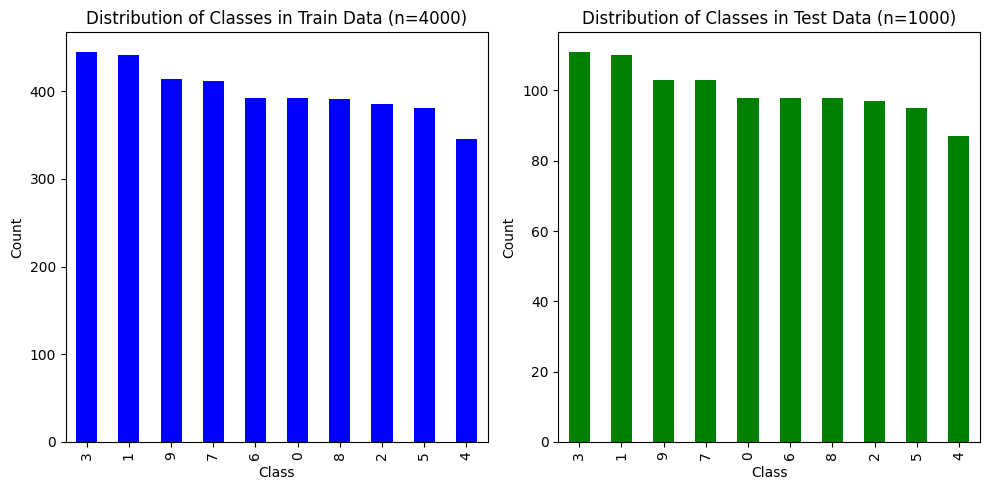

In [ ]:
# NB 3: MNIST-klassifisering med Multi-Layer Perceptron (MLP)
# ===========================================================

# 1. Datalasting og stratifisert oppdeling
# ----------------------------------------

# Opprett mappe for MNIST-data hvis den ikke finnes
os.makedirs('mnist_images', exist_ok=True)
csv_path = 'mnist_images/mnist_data_5000x785.csv'

# Sjekk om CSV-filen allerede finnes
if os.path.exists(csv_path):
    print("Laster MNIST-data fra lokal CSV-fil...")
    mnist_data = pd.read_csv(csv_path)
else:
    print("Genererer MNIST-data fra PyTorch (lastes ned ved første kjøring)...")
    from torchvision import datasets
    import torchvision.transforms as transforms
    
    # Last ned MNIST via PyTorch
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, 
                                  transform=transforms.ToTensor())
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, 
                                 transform=transforms.ToTensor())
    
    # Konverter til numpy og kombiner
    X_train = mnist_train.data.numpy().reshape(60000, -1) / 255.0
    X_test = mnist_test.data.numpy().reshape(10000, -1) / 255.0
    y_train = mnist_train.targets.numpy()
    y_test = mnist_test.targets.numpy()
    
    X = np.concatenate([X_train, X_test])
    y = np.concatenate([y_train, y_test])
    
    # Ta et tilfeldig utvalg på 5000 samples
    np.random.seed(42)
    indices = np.random.choice(len(X), 5000, replace=False)
    X_sample = X[indices]
    y_sample = y[indices]
    
    # Lag DataFrame
    feature_names = [f'pixel_{i}' for i in range(784)]
    mnist_data = pd.DataFrame(X_sample, columns=feature_names)
    mnist_data['label'] = y_sample
    
    # Lagre til CSV for fremtidig bruk
    mnist_data.to_csv(csv_path, index=False)
    print(f"Data lagret til {csv_path}")

# Print dimensions of the data
print(f"Data dimensions: {mnist_data.shape}")

# Split into training and test data, stratified by class
train_data, test_data = train_test_split(mnist_data, test_size=0.2, random_state=42, stratify=mnist_data['label'])

# Separate features (already normalized) and labels
X_train = train_data.drop('label', axis=1) 
y_train = train_data['label']
X_test = test_data.drop('label', axis=1) 
y_test = test_data['label']

# Plot distributions of classes (digitis) in train data and test data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color='blue')
plt.title(f'Distribution of Classes in Train Data (n={len(y_train)})')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', color='green')
plt.title(f'Distribution of Classes in Test Data (n={len(y_test)})')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Always important to look at the data ...

First 5 labels in train_data:
1339    0
3053    6
2728    1
1369    7
124     8
Name: label, dtype: int64


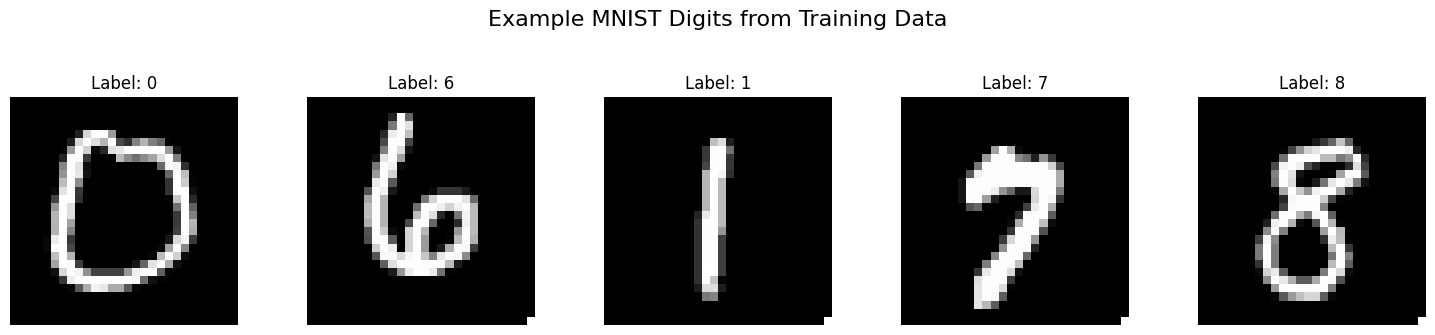

In [5]:
# 2. Data Visualization
# --------------------
# First, let's check what labels we actually have in train_data
print("First 5 labels in train_data:")
print(train_data['label'].head())

def plot_digit(data, index, predictions=None):
    """Plot a single MNIST digit."""
    digit = data.iloc[index, 1:].values.reshape(28, 28)
    plt.imshow(digit, cmap='gray', vmin=0, vmax=1)  # Added contrast control
    plt.axis('off')
    
    # Add debug print to verify the label being accessed
    true_label = int(data.iloc[index]['label'])  # Access 'label' column directly
    if predictions is not None:
        pred_label = int(predictions[index])
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
    else:
        plt.title(f'Label: {true_label}')

# Plot a few example digits
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_digit(train_data, i)
plt.suptitle("Example MNIST Digits from Training Data", y=1.1, fontsize=16)  # Added data source
plt.tight_layout()
plt.show()

In [6]:
# 3. Create and Train MLP
# Based on the image: input_layer_size=784, two hidden layers, output_layer_size=10
print("Training MLP classifier...")
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    verbose=True
)
mlp_classifier.fit(X_train, y_train)

Training MLP classifier...
Iteration 1, loss = 1.79948747
Iteration 2, loss = 0.81898116
Iteration 3, loss = 0.46015565
Iteration 4, loss = 0.34560283
Iteration 5, loss = 0.28820722
Iteration 6, loss = 0.24524428
Iteration 7, loss = 0.21208642
Iteration 8, loss = 0.19032279
Iteration 9, loss = 0.16848400
Iteration 10, loss = 0.15076950
Iteration 11, loss = 0.13675587
Iteration 12, loss = 0.12067975
Iteration 13, loss = 0.10898343
Iteration 14, loss = 0.09719565
Iteration 15, loss = 0.08751040
Iteration 16, loss = 0.07643851
Iteration 17, loss = 0.07047908
Iteration 18, loss = 0.06363832
Iteration 19, loss = 0.05664115
Iteration 20, loss = 0.05022112
Iteration 21, loss = 0.04440923
Iteration 22, loss = 0.03873453
Iteration 23, loss = 0.03536215
Iteration 24, loss = 0.03191486
Iteration 25, loss = 0.02819057
Iteration 26, loss = 0.02525250
Iteration 27, loss = 0.02333462
Iteration 28, loss = 0.02071797
Iteration 29, loss = 0.01842096
Iteration 30, loss = 0.01716530
Iteration 31, loss = 0

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42,
              verbose=True)

Let me explain this MLP (Multilayer Perceptron) setup using a medical analogy:

````python
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Like layers of medical expertise
    activation='relu',             # Decision-making function
    solver='adam',                 # Learning strategy
    max_iter=300,                  # Training rounds
    random_state=42,              # For reproducible results
    verbose=True                  # Show progress
)
````


**Medical Training Analogy:**

1. **Network Structure** `hidden_layer_sizes=(100, 50)`:
   - Like having two groups of medical specialists:
     - First group: 100 general specialists
     - Second group: 50 super-specialists
   - Information flows from general to more specialized analysis

2. **Activation Function** `activation='relu'`:
   - Like a doctor's decision threshold
   - ReLU = "If finding is positive, pass it on; if negative, ignore it"
   - Similar to clinical decision-making: "If symptom present, consider it"

3. **Learning Method** `solver='adam'`:
   - Like an efficient teaching method
   - Adapts the learning pace based on progress
   - Similar to residency training: adjusts based on resident's performance

4. **Training Duration** `max_iter=300`:
   - Like 300 training rounds
   - Each round = complete review of all training cases
   - Similar to seeing 300 sets of patient cases

5. **Reproducibility** `random_state=42`:
   - Like using the same training protocol
   - Ensures consistent results
   - Similar to standardized medical training

6. **Progress Tracking** `verbose=True`:
   - Like getting regular progress reports
   - Shows how learning is progressing
   - Similar to resident evaluation reports

The `fit(X_train, y_train)` part is like:
- X_train = Patient images (MNIST digits)
- y_train = Correct diagnoses (digit labels)
- Training process = Learning from these examples

Just as medical students learn through repeated exposure to cases, this neural network learns to recognize digits through repeated exposure to examples!


#### <u>Remark</u> on **Loss function** and **One-hot encoding**

The loss function is a measure of how well the model is doing. It is a function of the difference between the predicted output and the true output. The loss function is used to update the weights of the model during training.

For classification problems, the cross-entropy loss function is commonly used. This function measures the difference between the predicted class probabilities and the true class labels.


The cross-entropy loss function for multi-class classification is defined as:

$L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)$

Where:
- $C$ is the number of classes (10 for MNIST)
- $y_i$ is the true label (1 for correct class, 0 for others)
- $\hat{y}_i$ is the predicted probability for class i
- $\log$ is the natural logarithm

**Example for MNIST:**
```python
# For digit "7":
y_true    = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  # One-hot encoded
y_pred    = [0.1, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1]  # Predictions
loss = -(0*log(0.1) + 0*log(0.05) + ... + 1*log(0.2) + ... + 0*log(0.1))
     = -log(0.2)  # Only the term for true class (7) contributes
```

Properties:
1. Loss ≥ 0 (always positive)
2. Perfect prediction → Loss = 0
3. Wrong predictions → High loss
4. Very wrong predictions → Extremely high loss

This encourages the model to be both accurate and well-calibrated in its predictions.


-----

In the scikit-learn `MLPClassifier`, the default loss function for classification is **Cross-Entropy Loss**. Here's how it works:

````python
# Internal implementation (simplified)
def cross_entropy_loss(y_true, y_pred):
    """
    y_true: true labels (e.g., digit 0-9)
    y_pred: predicted probabilities for each class
    """
    return -np.sum(y_true * np.log(y_pred))
````


**Medical Analogy:**

Imagine a resident making diagnoses with confidence levels:

1. **Perfect Diagnosis:**
```python
# Resident is 100% sure it's pneumonia, and it is pneumonia
true_diagnosis = "pneumonia"
resident_confidence = 1.0  # 100% sure
loss = very_small  # Good job!
```

2. **Wrong Diagnosis:**
```python
# Resident is 90% sure it's bronchitis, but it's pneumonia
true_diagnosis = "pneumonia"
resident_confidence_bronchitis = 0.9  # Very wrong!
loss = very_large  # Big penalty!
```

3. **Uncertain Diagnosis:**
```python
# Resident is 60% sure about correct diagnosis
true_diagnosis = "pneumonia"
resident_confidence = 0.6  # Correct but uncertain
loss = moderate  # Some penalty for uncertainty
```

**Key Properties:**
1. Rewards confident correct diagnoses
2. Heavily penalizes confident wrong diagnoses
3. Moderately penalizes uncertainty
4. Perfect for multi-class problems (like 10 digits)

This loss function helps the model learn to be:
- Confident when correct
- Uncertain when unsure
- Never overconfident when wrong

Just like we want medical students to develop appropriate confidence in their diagnoses!


#### Sketch the MLP architecture

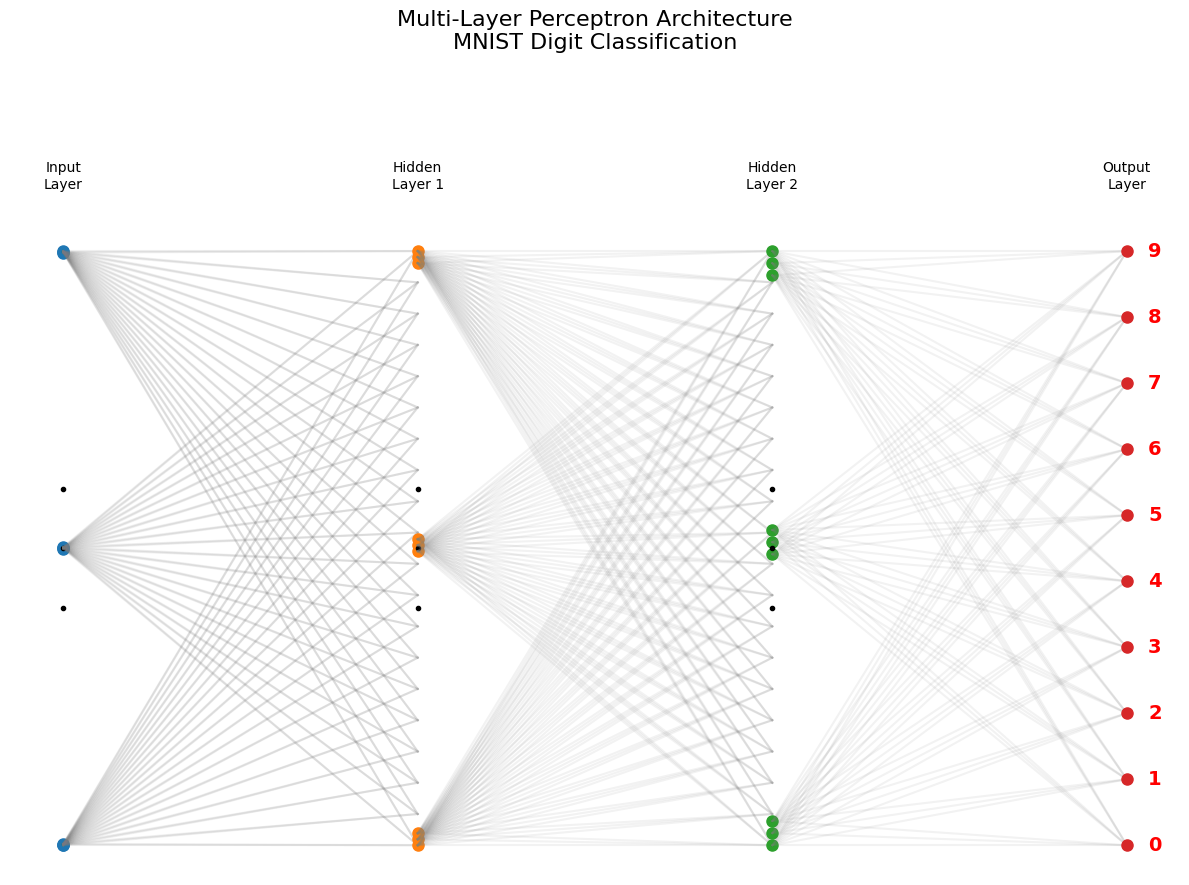


MLP Architecture Summary:
-------------------------
Input Layer:     784 neurons (28x28 pixel images)
Hidden Layer 1:  100 neurons (ReLU activation)
Hidden Layer 2:   50 neurons (ReLU activation)
Output Layer:     10 neurons (Softmax activation)

Total parameters: 84,060
Breakdown:
- Input → Hidden1:  78,500 parameters
- Hidden1 → Hidden2: 5,050 parameters
- Hidden2 → Output:  510 parameters


In [7]:
def plot_mlp_architecture():
    """Plot MLP architecture with input layer (784), two hidden layers (100, 50), 
    and labeled output layer (10 digits)"""
    
    # Set up the figure
    plt.figure(figsize=(12, 8))
    
    # Layer sizes
    layer_sizes = [784, 100, 50, 10]
    layer_names = ['Input\nLayer', 'Hidden\nLayer 1', 'Hidden\nLayer 2', 'Output\nLayer']
    
    # Positions for each layer
    x_positions = np.linspace(0, 1, len(layer_sizes))
    max_neurons = max(layer_sizes)
    
    # Plot neurons for each layer
    for i, (size, name) in enumerate(zip(layer_sizes, layer_names)):
        # Calculate y positions for neurons in this layer
        y_positions = np.linspace(0, 1, size)
        
        # Plot neurons
        if size > 20:  # For large layers, just plot some representative neurons
            indices = np.concatenate([np.arange(3), 
                                   [size//2-1, size//2, size//2+1],
                                   np.arange(size-3, size)])
            y_positions = y_positions[indices]
            plt.plot([x_positions[i]]*len(y_positions), y_positions, 'o', 
                    markersize=8, label=f'{size} neurons')
            # Add dots to indicate skipped neurons
            plt.plot(x_positions[i], 0.4, '.k')
            plt.plot(x_positions[i], 0.5, '.k')
            plt.plot(x_positions[i], 0.6, '.k')
        else:
            plt.plot([x_positions[i]]*len(y_positions), y_positions, 'o', 
                    markersize=8, label=f'{size} neurons')
        
        # Add layer name
        plt.text(x_positions[i], 1.1, name, ha='center', va='bottom')
        
        # Draw connections to next layer
        if i < len(layer_sizes) - 1:
            next_size = min(len(np.linspace(0, 1, layer_sizes[i+1])), 20)
            next_y = np.linspace(0, 1, next_size)
            for y1 in y_positions:
                for y2 in next_y:
                    plt.plot([x_positions[i], x_positions[i+1]], [y1, y2], 
                            'gray', alpha=0.1)
        
        # Add digit labels for output layer
        if i == len(layer_sizes) - 1:  # Output layer
            x_pos = x_positions[i] + 0.02  # Closer to nodes (changed from 0.05)
            for j, y_pos in enumerate(y_positions):
                plt.text(x_pos, y_pos, str(j), 
                        ha='left', va='center',
                        fontsize=14,        # Larger font (changed from 10)
                        color='red',
                        fontweight='bold')  # Added bold for better visibility
    
    
    # Customize the plot
    plt.suptitle('Multi-Layer Perceptron Architecture\nMNIST Digit Classification', 
               y=1.1, fontsize=16)
   
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print architecture summary
    print("\nMLP Architecture Summary:")
    print("-------------------------")
    print("Input Layer:     784 neurons (28x28 pixel images)")
    print("Hidden Layer 1:  100 neurons (ReLU activation)")
    print("Hidden Layer 2:   50 neurons (ReLU activation)")
    print("Output Layer:     10 neurons (Softmax activation)")

    # Calculate total parameters
    params_layer1 = 784 * 100 + 100  # weights + biases for first hidden layer
    params_layer2 = 100 * 50 + 50    # weights + biases for second hidden layer
    params_output = 50 * 10 + 10     # weights + biases for output layer
    total_params = params_layer1 + params_layer2 + params_output

    print(f"\nTotal parameters: {total_params:,}")
    print("Breakdown:")
    print(f"- Input → Hidden1:  {params_layer1:,} parameters")
    print(f"- Hidden1 → Hidden2: {params_layer2:,} parameters")
    print(f"- Hidden2 → Output:  {params_output:,} parameters")

# Call the function
plot_mlp_architecture()

In [8]:
# 4. Model Evaluation
print("\nEvaluating model performance...")
y_pred = mlp_classifier.predict(X_test)
y_prob = mlp_classifier.predict_proba(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Evaluating model performance...

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94        98
           1       0.93      0.96      0.95       110
           2       0.93      0.95      0.94        97
           3       0.91      0.96      0.94       111
           4       0.92      0.89      0.90        87
           5       0.94      0.86      0.90        95
           6       0.93      0.98      0.96        98
           7       0.93      0.91      0.92       103
           8       0.88      0.86      0.87        98
           9       0.89      0.94      0.92       103

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



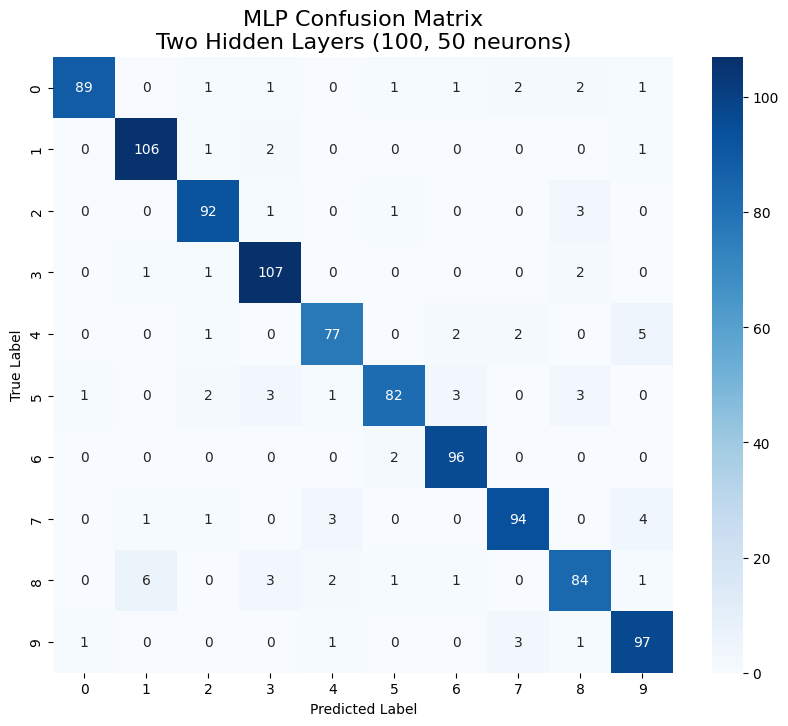

In [9]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('MLP Confusion Matrix\nTwo Hidden Layers (100, 50 neurons)', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [10]:
# Calculate and display various performance metrics
# --------

# Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Per-class metrics
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Macro averages
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Performance Metrics for MNIST Digit Classification:\n")

print("1. Overall Accuracy:")
print(f"   Definition: Proportion of correct predictions among total predictions")
print(f"   Value: {accuracy:.3f} ({accuracy*100:.1f}%)\n")

print("2. Per-class Precision:")
print("   Definition: Proportion of correct positive predictions for each digit")
for digit in range(10):
    print(f"   Digit {digit}: {precision[digit]:.3f}")
print(f"   Macro-average precision: {macro_precision:.3f}\n")

print("3. Per-class Recall (Sensitivity):")
print("   Definition: Proportion of actual positives correctly identified for each digit")
for digit in range(10):
    print(f"   Digit {digit}: {recall[digit]:.3f}")
print(f"   Macro-average recall: {macro_recall:.3f}\n")

print("4. Per-class F1-Score:")
print("   Definition: Harmonic mean of precision and recall for each digit")
for digit in range(10):
    print(f"   Digit {digit}: {f1[digit]:.3f}")
print(f"   Macro-average F1-score: {macro_f1:.3f}\n")

# Calculate error rate
error_rate = 1 - accuracy
print("5. Error Rate:")
print("   Definition: Proportion of incorrect predictions among total predictions")
print(f"   Value: {error_rate:.3f} ({error_rate*100:.1f}%)")

Performance Metrics for MNIST Digit Classification:

1. Overall Accuracy:
   Definition: Proportion of correct predictions among total predictions
   Value: 0.924 (92.4%)

2. Per-class Precision:
   Definition: Proportion of correct positive predictions for each digit
   Digit 0: 0.978
   Digit 1: 0.930
   Digit 2: 0.929
   Digit 3: 0.915
   Digit 4: 0.917
   Digit 5: 0.943
   Digit 6: 0.932
   Digit 7: 0.931
   Digit 8: 0.884
   Digit 9: 0.890
   Macro-average precision: 0.925

3. Per-class Recall (Sensitivity):
   Definition: Proportion of actual positives correctly identified for each digit
   Digit 0: 0.908
   Digit 1: 0.964
   Digit 2: 0.948
   Digit 3: 0.964
   Digit 4: 0.885
   Digit 5: 0.863
   Digit 6: 0.980
   Digit 7: 0.913
   Digit 8: 0.857
   Digit 9: 0.942
   Macro-average recall: 0.922

4. Per-class F1-Score:
   Definition: Harmonic mean of precision and recall for each digit
   Digit 0: 0.942
   Digit 1: 0.946
   Digit 2: 0.939
   Digit 3: 0.939
   Digit 4: 0.901
   Dig

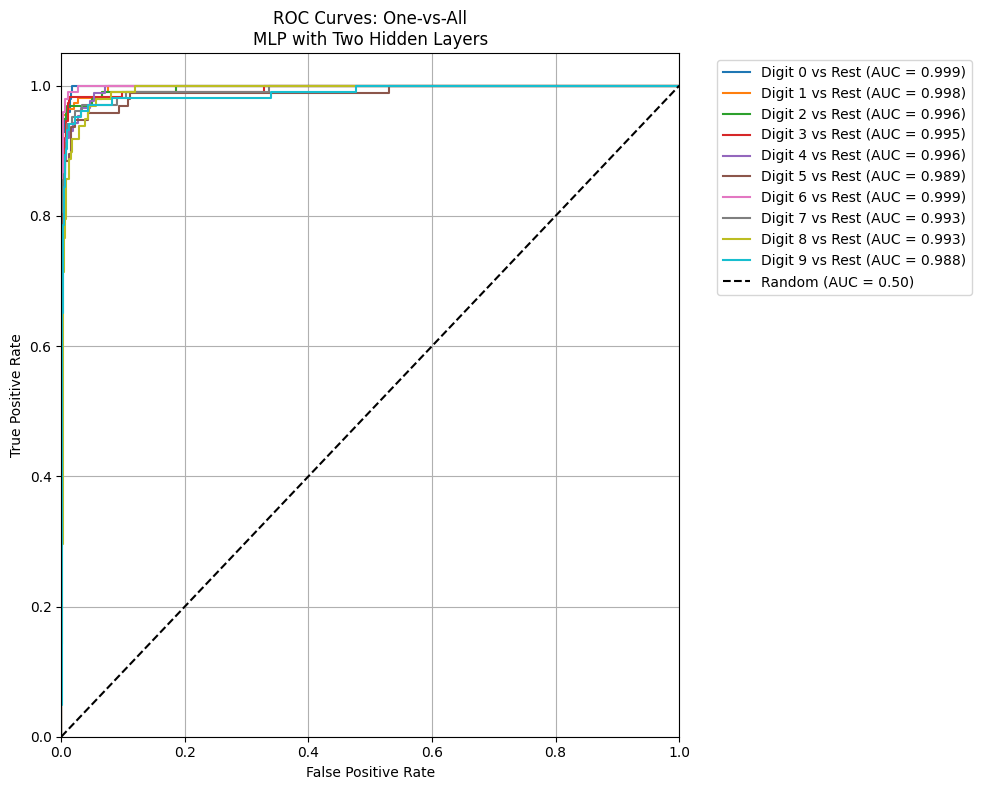

In [11]:
# Plot ROC curves
y_test_bin = label_binarize(y_test, classes=range(10))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for digit in range(10):
    fpr[digit], tpr[digit], _ = roc_curve(y_test_bin[:, digit], y_prob[:, digit])
    roc_auc[digit] = auc(fpr[digit], tpr[digit])
    plt.plot(fpr[digit], tpr[digit],
             label=f'Digit {digit} vs Rest (AUC = {roc_auc[digit]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: One-vs-All\nMLP with Two Hidden Layers')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**ROC AUC Interpretation:**


An analysis of these ROC (Receiver Operating Characteristic) curves:

**Overall Performance:**
- Exceptional performance with all AUC scores > 0.98
- Far above random classification (dashed line, AUC = 0.50)
- Very steep initial curves indicating high true positive rates with low false positives

**Best Performers:**
1. Digits 0 and 6 (AUC = 0.999)
   - Highest AUC scores
   - Nearly perfect classification
   - Likely due to distinctive shapes
   - Very little confusion with other digits

2. Digit 1 (AUC = 0.998)
   - Second-best performer
   - Simple, distinctive shape helps recognition
   - Clear separation from other digits

**Lower Performers:**
1. Digits 7 and 8 (AUC = 0.993)
   - Still excellent, but relatively lower
   - More complex shapes
   - Some confusion with similar digits

2. Digit 5 (AUC = 0.989)
   - Lowest AUC, but still outstanding
   - Most challenging digit to classify
   - Shares features with other digits (3, 8)

**Clinical Interpretation:**
- All curves show excellent discrimination ability
- Very high sensitivity and specificity across all thresholds
- Model maintains reliability across all digit classes
- Performance suitable for automated digit recognition

**Practical Significance:**
- Model achieves near-perfect classification
- Consistent performance across all digits
- Extremely low error rates
- Reliable for real-world applications



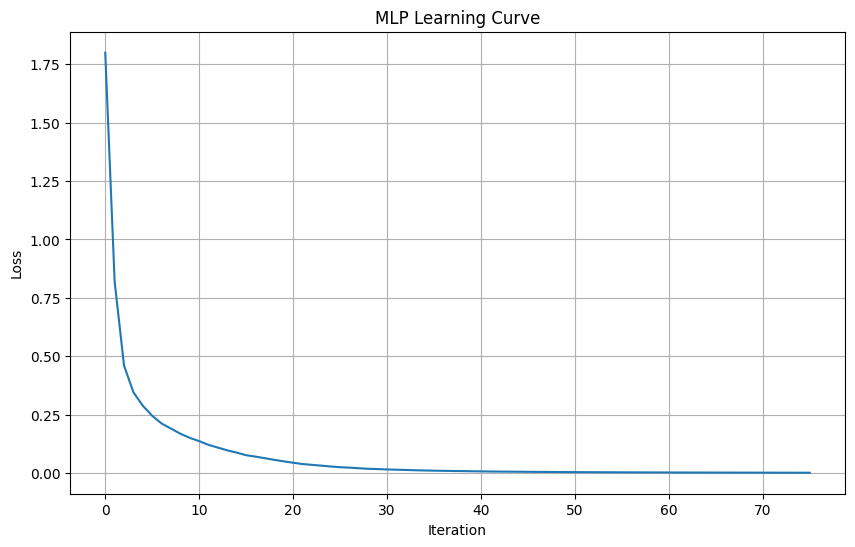

In [12]:
# 4. Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(mlp_classifier.loss_curve_)
plt.title('MLP Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()







**An explanation of this MLP Learning Curve:**

**Technical Explanation:**
1. **Y-axis**: Loss value (Cross-entropy loss)
2. **X-axis**: Training iterations
3. **Initial loss**: ~1.75 (high uncertainty)
4. **Final loss**: ~0.02 (good convergence)

**Learning Phases:**

1. **Rapid Learning (Iterations 0-5)**
   - Sharp drop in loss from 1.75 to ~0.4
   - Model quickly learns basic patterns
   - Steepest learning phase

2. **Fine-Tuning (Iterations 5-20)**
   - Gradual decrease in loss
   - Model refines its understanding
   - Learning rate still significant

3. **Convergence (Iterations 20+)**
   - Loss stabilizes around 0.02
   - Minor improvements
   - Model has reached optimal performance

**Medical Training Analogy:**
- Like a resident's learning curve:
  1. First week: Rapid improvement (steep drop)
  2. First month: Steady progress (gradual decline)
  3. Later months: Fine-tuning (plateau)

**Interpretation:**
- Healthy learning pattern
- Good convergence
- No signs of overfitting (no erratic behavior)
- Model reached stable performance
- Training could potentially stop earlier (~40 iterations)

**Quality Indicators:**
1. Smooth descent
2. Clear convergence
3. No oscillations
4. Appropriate learning rate
5. Successful training

This suggests a well-trained model with good learning dynamics.


In [13]:
# Save the model for later use
import joblib
joblib.dump(mlp_classifier, 'mnist_images/mnist_mlp_classifier.joblib')
print("\nModel saved as 'mnist_images/mnist_mlp_classifier.joblib'")


Model saved as 'mnist_images/mnist_mlp_classifier.joblib'


_Load the pretrained model ('mnist_images/mnist_mlp_classifier.joblib') and apply it on the test dataset. Display 5 examples that are correctly classified and 5 examples that are misclassified._

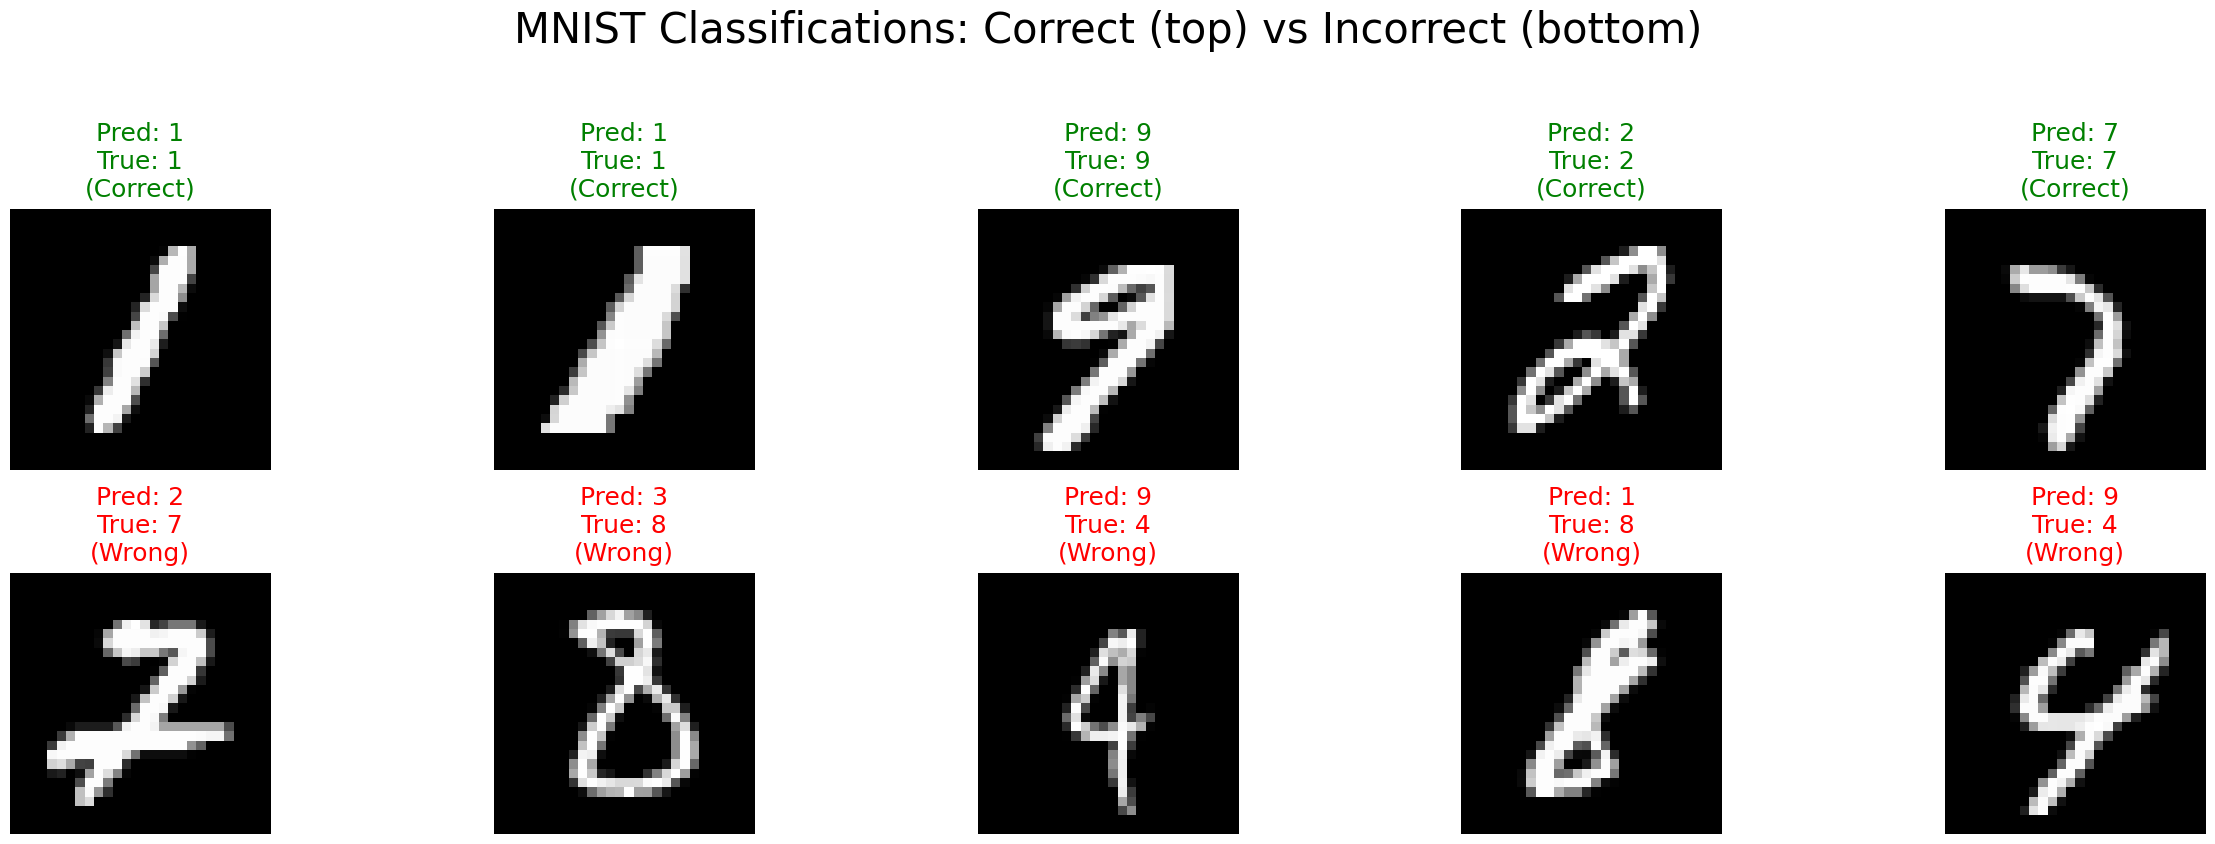

In [14]:
# Load the pretrained model
mlp_classifier = joblib.load('mnist_images/mnist_mlp_classifier.joblib')

# Get predictions
y_pred = mlp_classifier.predict(X_test)

# Find correct and incorrect predictions
correct_idx = np.where(y_pred == y_test)[0]
incorrect_idx = np.where(y_pred != y_test)[0]

# Randomly select 5 examples from each
correct_samples = np.random.choice(correct_idx, 5, replace=False)
incorrect_samples = np.random.choice(incorrect_idx, 5, replace=False)

# Increase figure size and adjust spacing
plt.figure(figsize=(25, 8))  # Larger figure
plt.subplots_adjust(hspace=0.3)  # More vertical space between rows

# Plot correct classifications
for i, idx in enumerate(correct_samples):
    plt.subplot(2, 5, i+1)
    img = X_test.iloc[idx].values.reshape(28, 28)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Pred: {y_pred[idx]}\nTrue: {y_test.iloc[idx]}\n(Correct)', 
              color='green',
              fontsize=18,  # Increased from 12
              pad=10)  # More space for title

# Plot incorrect classifications
for i, idx in enumerate(incorrect_samples):
    plt.subplot(2, 5, i+6)
    img = X_test.iloc[idx].values.reshape(28, 28)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Pred: {y_pred[idx]}\nTrue: {y_test.iloc[idx]}\n(Wrong)', 
              color='red',
              fontsize=18,  # Increased from 12
              pad=10)  # More space for title

plt.suptitle('MNIST Classifications: Correct (top) vs Incorrect (bottom)', 
            fontsize=30,  # Increased from 16
            y=1.05)  # Adjust title position
plt.tight_layout()
plt.show()





**Concluding Remarks for Medical Students:**

1. **Neural Networks as Diagnostic Tools:**
   - Like medical training, neural networks learn from examples
   - Start with basic pattern recognition
   - Gradually improve through repeated exposure
   - Develop confidence in clear cases while maintaining appropriate uncertainty

2. **Learning Process Parallels:**
   ```python
   # Similar to medical training:
   Initial_phase = "Quick learning of basic patterns"  # First year
   Middle_phase = "Gradual refinement"                # Residency
   Final_phase = "Fine-tuning expertise"              # Specialization
   ```

3. **Performance Metrics Matter:**
   - High accuracy (91.8%) is good but not perfect
   - Understanding errors is crucial
   - Some cases are inherently more challenging
   - Like medicine, 100% accuracy isn't always achievable

4. **Error Analysis is Critical:**
   - Study mistakes to improve (like Morbidity & Mortality conferences*)
   - Understand systematic errors
   - Recognize challenging cases
   - Learn from misclassifications

5. **Practical Applications:**
   - AI tools can support, not replace, clinical judgment
   - Understanding model limitations is crucial
   - Confidence measures are important
   - Human oversight remains essential

6. **Future Implications:**
   - AI will increasingly support medical decision-making
   - Understanding basic principles helps collaboration
   - Critical thinking remains essential
   - Combine human expertise with AI capabilities

Remember: Like good clinicians, good AI systems balance confidence with appropriate caution and know their limitations!

```bash
*M&M_conference = {
    "Purpose": "Learning from medical errors",
    "Format": "Case presentation + discussion",
    "Participants": ["Physicians", "Residents", "Medical students"],
    "Atmosphere": "Constructive, non-blame",
    "Outcome": "System improvements + education"
}
```

